In [1]:
%cd ..

/home/apere/Sync/Developpement/graphConvNet


# Learning an Auto Encoder over MNIST

In this notebook, we are going to learn an autoencoder over the mnist data. We have purposely used non approximated localized layers (no Chebyshev Recursive formulation), and Transition Matrix based max pooling and un pooling, to allow interpretation of results over graphical structures. Performances in terms of computational costs, are therefore, not optimals, and could be improved by Lanczos or Chebyshev approximated filters, and 1D Max Pooling on sorted indexes.

The structure will be the following one:

1. Graphical Encoder made out of 4 such Graph Conv Stacks:
    + Graph Conv Stack
        + Graphical Convolution, with size of neighbourhood 5 and 1 filter
        + Relu non linearity
        + Graphical Max Pooling $\sim$ 2
2. Graphical Decoder made out of 4 such Graph Unconv Stacks:
    + Graph UnConv Stack
        + Graphical UnPooling $\sim$ 2
        + Relu non linearity
        + Graphical Convolution, with size of neighbourhood 5 and 1 filter
        
Or represented as a figure:
        
![Autoencoder Architecture](../report/img/autoencoder.png)

## Experiment

In [2]:
# Imports
import sys, os
sys.path.insert(0,os.getcwd())
import pygsp
import numpy
import tensorflow as tf
import scipy.misc
import matplotlib.pyplot as plt
import scipy.signal
from src.mnist import load_mnist
from src.coarsening import computeCoarsening, computeCoarsenedCoords
import random

numpy.set_printoptions(threshold=numpy.nan)
from IPython.display import clear_output
%matplotlib inline

We are going to use MNIST dataset, with standardization in [0;1] as only pre processing. 

In [3]:
# Load mnist dataset
training_mnist = load_mnist(dataset='training')
testing_mnist = load_mnist(dataset='testing')

training_data = numpy.reshape(training_mnist[0], [training_mnist[0].shape[0],28*28])
training_data = training_data/255.0
training_labels = training_mnist[1]
training_cats = numpy.zeros([training_labels.shape[0], 10])
for i in range(0,training_labels.shape[0]):
    training_cats[i][training_labels[i]]=1
    
testing_data = numpy.reshape(testing_mnist[0], [testing_mnist[0].shape[0],28*28])
testing_data = testing_data/255.0
testing_labels = testing_mnist[1]
testing_cats = numpy.zeros([testing_labels.shape[0], 10])
for i in range(0,testing_labels.shape[0]):
    testing_cats[i][testing_labels[i]]=1

We will use a grid graph as structure for our image signal. We can plot a sample on this grid:

Plotting 1 sample from training data


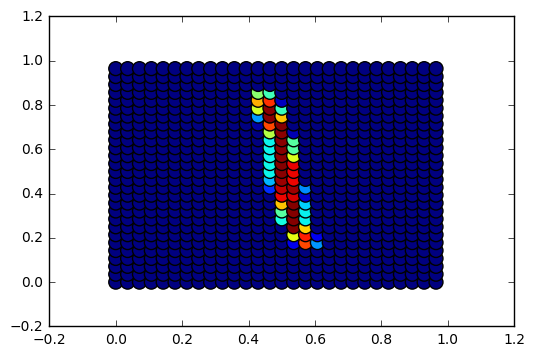

In [4]:
# Create graph grid
gsz = 28
g1 = pygsp.graphs.Grid2d(gsz)

# Plot random signal on the grid
idx = random.randint(0, training_mnist[0].shape[0])
sample = training_data[idx]
print("Plotting %i sample from training data"%training_labels[idx])
pygsp.plotting.plot_signal(g1, sample)

Now we have to compute coarsened graphs Weight and Transition matrices. Those will be useful to compute the max pooling in our cnn. We also create graphs object with nodes coordinates equals to the mean of parents coordinates. This will allows us to plot filtered and pooled signals on understandable structures.

In [4]:
# Coarsen graph

# Level 1
W2, T12 = computeCoarsening(g1.W.todense())
g2 = pygsp.graphs.Graph(W2)
g2.coords = computeCoarsenedCoords(g1.coords,T12)

# Level 2
W3, T23 = computeCoarsening(g2.W.todense())
g3 = pygsp.graphs.Graph(W3)
g3.coords = computeCoarsenedCoords(g2.coords,T23)

# Level 3
W4, T34 = computeCoarsening(g3.W.todense())
g4 = pygsp.graphs.Graph(W4)
g4.coords = computeCoarsenedCoords(g3.coords,T34)

# Level 4
W5, T45 = computeCoarsening(g4.W.todense())
g5 = pygsp.graphs.Graph(W5)
g5.coords = computeCoarsenedCoords(g4.coords,T45)

We compute normalized laplacians that will be used for filtering.

In [5]:
# Compute the normalized laplacians

g1.create_laplacian(lap_type='normalized')
g1.compute_fourier_basis(force_recompute=True)
L1n = (2/g1.lmax)*g1.L.todense() - numpy.eye(g1.L.shape[0])
dim1 = L1n.shape[0]

g2.create_laplacian(lap_type='normalized')
g2.compute_fourier_basis(force_recompute=True)
L2n = (2/g2.lmax)*g2.L.todense() - numpy.eye(g2.L.shape[0])
dim2 = L2n.shape[0]

g3.create_laplacian(lap_type='normalized')
g3.compute_fourier_basis(force_recompute=True)
L3n = (2/g3.lmax)*g3.L.todense() - numpy.eye(g3.L.shape[0])
dim3 = L3n.shape[0]

g4.create_laplacian(lap_type='normalized')
g4.compute_fourier_basis(force_recompute=True)
L4n = (2/g4.lmax)*g4.L.todense() - numpy.eye(g4.L.shape[0])
dim4 = L4n.shape[0]

g5.create_laplacian(lap_type='normalized')
g5.compute_fourier_basis(force_recompute=True)
L5n = (2/g5.lmax)*g5.L.todense() - numpy.eye(g5.L.shape[0])
dim5 = L5n.shape[0]

We instantiate a tensorflow session and define the computation graph.

In [6]:
# We instantiate Session object
sess = tf.InteractiveSession()

## Input ## ==================================================================================================
x = tf.placeholder(tf.float32, shape=[None,dim1])              # x    : [None, dim1]
xc = tf.expand_dims(x, 1)                                      # xc   : [None, 1, dim1] channeled representation
n0 = 1                                                         # number of input channels
k = 5

## GConvStack1 ## ============================================================================================

## GConv ## --------------------------------------------------------------------------------------------------
k1 = k                                                         # Max neighbour distance for filters  
n1 = 1                                                         # Number of filters
n1i = n0                                                       # Number of input channels
e1 = numpy.ndarray([k1, g1.e.shape [0]])
# Load power of \Lambda
for i in range(0,k1):
    e1[i] = numpy.power(g1.e,i)
# Declare Layer variables and constants
eig1 = tf.constant(e1, dtype=tf.float32)                       # eig1 : [k1, dim1]
U1 = tf.constant(g1.U, dtype=tf.float32)                       # U1   : [dim1, dim1]
W1 = tf.Variable(tf.truncated_normal([n1, k1], stddev=0.1))    # W1   : [n1, k1]
b1 = tf.Variable(tf.constant(0.1, shape=[n1]))                 # b1   : [n1]
# We put into Fourier Basis
x1f = tf.reshape(xc, [-1, dim1])                               # x1f  : [None*n1i, dim1]
x1f = tf.matmul(U1,x1f,transpose_a=True, transpose_b=True)     # x1f  : [dim1, None*n1i]
x1f = tf.reshape(tf.transpose(x1f),[-1, n1i, dim1])            # x1f  : [None, n1i, dim1]
# We compute filters
f1f = tf.expand_dims(tf.transpose(W1),1)                       # f1f  : [k1, 1, n1]
f1f = tf.mul(tf.expand_dims(eig1,2), f1f)                      # f1f  : [k1, dim1, n1]
f1f = tf.reduce_sum(f1f,axis=0)                                # f1f  : [dim1, n1]
f1f = tf.add(tf.expand_dims(b1,0), f1f)                        # f1f  : [dim1, n1]
f1f = tf.expand_dims(tf.transpose(f1f), 0)                     # f1f  : [1, n1, dim1]
# We filter the signal
x1f = tf.expand_dims(x1f,1)                                    # x1f  : [None, 1, n1i, dim1]
f1f = tf.expand_dims(f1f,2)                                    # f1f  : [1, n1, 1, dim1]
y1f = tf.mul(x1f,f1f)                                          # y1f  : [None, n1, n1i, dim1]
y1f = tf.reshape(y1f, [-1, n1*n1i, dim1])                      # y1f  : [None, n1*n1i, dim1]
y1f = tf.transpose(y1f)                                        # y1f  : [dim1, n1*n1i, None]
# We move back to the normal basis
y1 = tf.reshape(y1f, [dim1,-1])                                # y1   : [dim1, None*n1*n1i]
y1 = tf.batch_matmul(U1,y1)                                    # y1   : [dim1, None*n1*n1i]
y1 = tf.reshape(y1, [dim1,n1*n1i,-1])                          # y1   : [dim1, n1*n1i, None]
y1 = tf.transpose(y1)                                          # y1   : [None, n1*n1i, dim1]

## Squash ## ------------------------------------------------------------------------------------------------
y1 = tf.nn.relu(y1)                                            # y1   : [None, n1*n1i, dim1]

## GPool ## -------------------------------------------------------------------------------------------------
TR12 = tf.constant(T12, dtype=tf.float32)                      # TR12 : [dim2, dim1]
y1p = tf.transpose(y1)                                         # y1p  : [dim1, n1*n1i, None]
y1p = tf.reshape(y1p, [dim1, -1])                              # y1p  : [dim1, n1*n1i*None]
y1p = tf.expand_dims(y1p, 0)                                   # y1p  : [1, dim1, n1*n1i*None]
y1p = tf.mul(tf.expand_dims(TR12, 2),y1p)                      # y1p  : [dim2, dim1, n1*n1i*None]
y1p = tf.reduce_max(y1p, axis=1)                               # y1p  : [dim2, n1*n1i*None]
y1p = tf.reshape(y1p, [TR12.get_shape()[0].value, n1*n1i, -1]) # y1p  : [dim2, n1*n1i, None]
y1p = tf.transpose(y1p)                                        # y1p  : [None, n1*n1i, dim2]

## GConvStack2 ## ============================================================================================

## GConv1 ## -------------------------------------------------------------------------------------------------
k2 = k
n2 = 1
n2i = n1*n1i 
e2 = numpy.ndarray([k2, g2.e.shape[0]])
# Load power of \Lambda
for i in range(0,k2):
    e2[i] = numpy.power(g2.e,i)
# Declare Layer variables and constants
eig2 = tf.constant(e2, dtype=tf.float32)
U2 = tf.constant(g2.U, dtype=tf.float32)
W2 = tf.Variable(tf.truncated_normal([n2, k2], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[n2]))
# We put into Fourier Basis
x2f = tf.reshape(y1p, [-1, dim2])
x2f = tf.matmul(U2,x2f,transpose_a=True, transpose_b=True)
x2f = tf.reshape(tf.transpose(x2f),[-1, n2i, dim2])
# We compute filters
f2f = tf.expand_dims(tf.transpose(W2),1)
f2f = tf.mul(tf.expand_dims(eig2,2), f2f)
f2f = tf.reduce_sum(f2f,axis=0)
f2f = tf.add(tf.expand_dims(b2,0), f2f) 
f2f = tf.expand_dims(tf.transpose(f2f), 0)
# We filter the signal           
x2f = tf.expand_dims(x2f,1)
f2f = tf.expand_dims(f2f,2)
y2f = tf.mul(x2f,f2f)
y2f = tf.reshape(y2f, [-1, n2*n2i, dim2])
y2f = tf.transpose(y2f)
# We move back to the normal basis
y2 = tf.reshape(y2f, [dim2,-1])
y2 = tf.batch_matmul(U2,y2)
y2 = tf.reshape(y2, [dim2,n2*n2i,-1])
y2 = tf.transpose(y2)

## Squash ## ------------------------------------------------------------------------------------------------
y2 = tf.nn.relu(y2)

## GPool ## -------------------------------------------------------------------------------------------------
TR23 = tf.constant(T23, dtype=tf.float32)
y2p = tf.transpose(y2)
y2p = tf.reshape(y2p, [dim2, -1])
y2p = tf.expand_dims(y2p, 0)
y2p = tf.mul(tf.expand_dims(TR23, 2),y2p)
y2p = tf.reduce_max(y2p, axis=1)
y2p = tf.reshape(y2p, [TR23.get_shape()[0].value, n2*n2i, -1])
y2p = tf.transpose(y2p)

## GConvStack3 ##=============================================================================================

## GConv ## --------------------------------------------------------------------------------------------------
k3 = k
n3 = 1 
n3i = n2*n2i
e3 = numpy.ndarray([k3, g3.e.shape[0]])
# Load power of \Lambda
for i in range(0,k3):
    e3[i] = numpy.power(g3.e,i)
# Declare Layer variables and constants
eig3 = tf.constant(e3, dtype=tf.float32)
U3 = tf.constant(g3.U, dtype=tf.float32)
W3 = tf.Variable(tf.truncated_normal([n3, k3], stddev=0.1))
b3 = tf.Variable(tf.constant(0.1, shape=[n3]))
# We put into Fourier Basis
x3f = tf.reshape(y2p, [-1, dim3])
x3f = tf.matmul(U3,x3f,transpose_a=True, transpose_b=True)
x3f = tf.reshape(tf.transpose(x3f),[-1, n2, dim3])
# We compute filters
f3f = tf.expand_dims(tf.transpose(W3),1)
f3f = tf.mul(tf.expand_dims(eig3,2), f3f)
f3f = tf.reduce_sum(f3f,axis=0)
f3f = tf.add(tf.expand_dims(b3,0), f3f) 
f3f = tf.expand_dims(tf.transpose(f3f), 0)
# We filter the signal                         
x3f = tf.expand_dims(x3f,1)
f3f = tf.expand_dims(f3f,2)
y3f = tf.mul(x3f,f3f)
y3f = tf.reshape(y3f, [-1, n3*n3i, dim3])
y3f = tf.transpose(y3f)
# We move back to the normal basis
y3 = tf.reshape(y3f, [dim3,-1])
y3 = tf.batch_matmul(U3,y3)
y3 = tf.reshape(y3, [dim3,n3*n3i,-1])
y3 = tf.transpose(y3)

## Squash ## ------------------------------------------------------------------------------------------------
y3 = tf.nn.relu(y3)

## GPool ## -------------------------------------------------------------------------------------------------
TR34 = tf.constant(T34, dtype=tf.float32)
y3p = tf.transpose(y3)
y3p = tf.reshape(y3p, [dim3, -1])
y3p = tf.expand_dims(y3p, 0)
y3p = tf.mul(tf.expand_dims(TR34, 2),y3p)
y3p = tf.reduce_max(y3p, axis=1)
y3p = tf.reshape(y3p, [TR34.get_shape()[0].value, n3*n3i, -1])
y3p = tf.transpose(y3p)

## GConvStack4 ## ============================================================================================

## GConv ## --------------------------------------------------------------------------------------------------
k4 = k
n4 = 1
n4i = n3*n3i
e4 = numpy.ndarray([k4, g4.e.shape[0]])
# Load power of \Lambda
for i in range(0,k4):
    e4[i] = numpy.power(g4.e,i)
# Declare Layer variables and constants
eig4 = tf.constant(e4, dtype=tf.float32)
U4 = tf.constant(g4.U, dtype=tf.float32)
W4 = tf.Variable(tf.truncated_normal([n4, k4], stddev=0.1))
b4 = tf.Variable(tf.constant(0.1, shape=[n4]))
# We put into Fourier Basis
x4f = tf.reshape(y3p, [-1, dim4])
x4f = tf.matmul(U4,x4f,transpose_a=True, transpose_b=True)
x4f = tf.reshape(tf.transpose(x4f),[-1, n3, dim4])
# We compute filters
f4f = tf.expand_dims(tf.transpose(W4),1)
f4f = tf.mul(tf.expand_dims(eig4,2), f4f)
f4f = tf.reduce_sum(f4f,axis=0)
f4f = tf.add(tf.expand_dims(b4,0), f4f) 
f4f = tf.expand_dims(tf.transpose(f4f), 0)
# We filter the signal                         
x4f = tf.expand_dims(x4f,1)
f4f = tf.expand_dims(f4f,2)
y4f = tf.mul(x4f,f4f)
y4f = tf.reshape(y4f, [-1, n4*n4i, dim4])
y4f = tf.transpose(y4f)
# We move back to the normal basis
y4 = tf.reshape(y4f, [dim4,-1])
y4 = tf.batch_matmul(U4,y4)
y4 = tf.reshape(y4, [dim4,n4*n4i,-1])
y4 = tf.transpose(y4)

## Squash ## ------------------------------------------------------------------------------------------------
y4 = tf.nn.relu(y4)

## GPool ## -------------------------------------------------------------------------------------------------
TR45 = tf.constant(T45, dtype=tf.float32)
y4p = tf.transpose(y4)
y4p = tf.reshape(y4p, [dim4, -1])
y4p = tf.expand_dims(y4p, 0)
y4p = tf.mul(tf.expand_dims(TR45, 2),y4p)
y4p = tf.reduce_max(y4p, axis=1)
y4p = tf.reshape(y4p, [TR45.get_shape()[0].value, n4*n4i, -1])
y4p = tf.transpose(y4p)

## GUnConvStack1 ## =========================================================================================

## GUnPool ## -----------------------------------------------------------------------------------------------
n6i = 1                                                          # Number of input channels
# We unpool     
y6u = tf.reshape(tf.transpose(y4p), [dim5, -1])                  # y6u   : [66, 1*None]
y6u = tf.expand_dims(y6u,0)                                      # y6u   : [1, 66, 1*None]
y6u = tf.mul(y6u, tf.expand_dims(tf.transpose(TR45),2))          # y6u   : [125, 66, 1*None]
y6u = tf.reduce_sum(y6u, axis=1)                                 # y6u   : [125,1*None]
y6u = tf.reshape(y6u, [dim4, n6i, -1])                           # y6u   : [125, 1, None]

## Squash ## ------------------------------------------------------------------------------------------------
y6u = tf.nn.relu(y6u)                                            # y6u   : [125, 1, None]
y6u = tf.transpose(y6u)                                          # y6u   : [None, 1, 125] 

## GConv ## -------------------------------------------------------------------------------------------------
k6 = k
n6 = 1
# Declare Layer variables and constants
W6 = tf.Variable(tf.truncated_normal([n6, k6], stddev=0.1))
b6 = tf.Variable(tf.constant(0.1, shape=[n6]))
# We put into Fourier Basis
x6f = tf.reshape(y6u, [-1, dim4])
x6f = tf.matmul(U4,x6f,transpose_a=True, transpose_b=True)
x6f = tf.reshape(tf.transpose(x6f),[-1, n3, dim4])
# We compute filters
f6f = tf.expand_dims(tf.transpose(W6),1)
f6f = tf.mul(tf.expand_dims(eig4,2), f6f)
f6f = tf.reduce_sum(f6f,axis=0)
f6f = tf.add(tf.expand_dims(b6,0), f6f) 
f6f = tf.expand_dims(tf.transpose(f6f), 0)
# We filter the signal                         
x6f = tf.expand_dims(x6f,1)
f6f = tf.expand_dims(f6f,2)
y6f = tf.mul(x6f,f6f)
y6f = tf.reshape(y6f, [-1, n6*n6i, dim4])
y6f = tf.transpose(y6f)
# We move back to the normal basis
y6 = tf.reshape(y6f, [dim4,-1])
y6 = tf.batch_matmul(U4,y6)
y6 = tf.reshape(y6, [dim4,n6*n6i,-1])
y6 = tf.transpose(y6)

## GUnConvStack2 ## =========================================================================================

## GUnPool ## -----------------------------------------------------------------------------------------------
n7i = 1
# We unpool 
y7u = tf.reshape(tf.transpose(y6), [dim4, -1])
y7u = tf.expand_dims(y7u,0)
y7u = tf.mul(y7u, tf.expand_dims(tf.transpose(TR34),2))
y7u = tf.reduce_sum(y7u, axis=1)  
y7u = tf.reshape(y7u, [dim3, n7i, -1])

## Squash ## ------------------------------------------------------------------------------------------------
y7u = tf.nn.relu(y7u)
y7u = tf.transpose(y7u)

## GConv ## -------------------------------------------------------------------------------------------------
k7 = k
n7 = 1
# Declare Layer variables and constants
W7 = tf.Variable(tf.truncated_normal([n7, k7], stddev=0.1))
b7 = tf.Variable(tf.constant(0.1, shape=[n7]))
# We put into Fourier Basis
x7f = tf.reshape(y7u, [-1, dim3])
x7f = tf.matmul(U3,x7f,transpose_a=True, transpose_b=True)
x7f = tf.reshape(tf.transpose(x7f),[-1, n7, dim3])
# We compute filters
f7f = tf.expand_dims(tf.transpose(W7),1)
f7f = tf.mul(tf.expand_dims(eig3,2), f7f)
f7f = tf.reduce_sum(f7f,axis=0)
f7f = tf.add(tf.expand_dims(b7,0), f7f) 
f7f = tf.expand_dims(tf.transpose(f7f), 0)
# We filter the signal                         
x7f = tf.expand_dims(x7f,1)
f7f = tf.expand_dims(f7f,2)
y7f = tf.mul(x7f,f7f)
y7f = tf.reshape(y7f, [-1, n7*n7i, dim3])
y7f = tf.transpose(y7f)
# We move back to the normal basis
y7 = tf.reshape(y7f, [dim3,-1])
y7 = tf.batch_matmul(U3,y7)
y7 = tf.reshape(y7, [dim3,n7*n7i,-1])
y7 = tf.transpose(y7)

## GUnConvStack3 ## =========================================================================================

## GUnPool ## -----------------------------------------------------------------------------------------------
n8i = 1
# We unpool 
y8u = tf.reshape(tf.transpose(y7), [dim3, -1])
y8u = tf.expand_dims(y8u,0)
y8u = tf.mul(y8u, tf.expand_dims(tf.transpose(TR23),2))
y8u = tf.reduce_sum(y8u, axis=1)  
y8u = tf.reshape(y8u, [dim2, n8i, -1])

## Squash ## ------------------------------------------------------------------------------------------------
y8u = tf.nn.relu(y8u)
y8u = tf.transpose(y8u)

## GConv ## -------------------------------------------------------------------------------------------------
k8 = k
n8 = 1
# Declare Layer variables and constants
W8 = tf.Variable(tf.truncated_normal([n8, k8], stddev=0.1))
b8 = tf.Variable(tf.constant(0.1, shape=[n8]))
# We put into Fourier Basis
x8f = tf.reshape(y8u, [-1, dim2])
x8f = tf.matmul(U2,x8f,transpose_a=True, transpose_b=True)
x8f = tf.reshape(tf.transpose(x8f),[-1, n8, dim2])
# We compute filters
f8f = tf.expand_dims(tf.transpose(W8),1)
f8f = tf.mul(tf.expand_dims(eig2,2), f8f)
f8f = tf.reduce_sum(f8f,axis=0)
f8f = tf.add(tf.expand_dims(b8,0), f8f) 
f8f = tf.expand_dims(tf.transpose(f8f), 0)
# We filter the signal                         
x8f = tf.expand_dims(x8f,1)
f8f = tf.expand_dims(f8f,2)
y8f = tf.mul(x8f,f8f)
y8f = tf.reshape(y8f, [-1, n8*n8i, dim2])
y8f = tf.transpose(y8f)
# We move back to the normal basis
y8 = tf.reshape(y8f, [dim2,-1])
y8 = tf.batch_matmul(U2,y8)
y8 = tf.reshape(y8, [dim2,n8*n8i,-1])
y8 = tf.transpose(y8)

## GUnConvStack4 ## =========================================================================================

## GUnPool ## -----------------------------------------------------------------------------------------------
n9i = 1
# We unpool 
y9u = tf.reshape(tf.transpose(y8), [dim2, -1])
y9u = tf.expand_dims(y9u,0)
y9u = tf.mul(y9u, tf.expand_dims(tf.transpose(TR12),2))
y9u = tf.reduce_sum(y9u, axis=1)  
y9u = tf.reshape(y9u, [dim1, n9i, -1])

## Squash ## ------------------------------------------------------------------------------------------------
y9u = tf.nn.relu(y9u)
y9u = tf.transpose(y9u)

## GConv ## -------------------------------------------------------------------------------------------------
k9 = k
n9 = 1
# Declare Layer variables and constants
W9 = tf.Variable(tf.truncated_normal([n9, k9], stddev=0.1))
b9 = tf.Variable(tf.constant(0.1, shape=[n9]))
# We put into Fourier Basis
x9f = tf.reshape(y9u, [-1, dim1])
x9f = tf.matmul(U1,x9f,transpose_a=True, transpose_b=True)
x9f = tf.reshape(tf.transpose(x9f),[-1, n9, dim1])
# We compute filters
f9f = tf.expand_dims(tf.transpose(W9),1)
f9f = tf.mul(tf.expand_dims(eig1,2), f9f)
f9f = tf.reduce_sum(f9f,axis=0)
f9f = tf.add(tf.expand_dims(b9,0), f9f) 
f9f = tf.expand_dims(tf.transpose(f9f), 0)
# We filter the signal                         
x9f = tf.expand_dims(x9f,1)
f9f = tf.expand_dims(f9f,2)
y9f = tf.mul(x9f,f9f)
y9f = tf.reshape(y9f, [-1, n9*n9i, dim1])
y9f = tf.transpose(y9f)
# We move back to the normal basis
y9 = tf.reshape(y9f, [dim1,-1])
y9 = tf.batch_matmul(U1,y9)
y9 = tf.reshape(y9, [dim1,n9*n9i,-1])
y9 = tf.transpose(y9)

## Output ## ================================================================================================
ygcnn = tf.reshape(y9,[-1,dim1])
y = tf.placeholder(tf.float32, shape=[None, dim1])

(?, 1, 67)


We define the loss.

In [7]:
# Define Loss
distance = tf.nn.l2_loss(tf.subtract(ygcnn,y))
weights   = tf.trainable_variables() 
weights_decay = tf.add_n([tf.nn.l2_loss(v) for v in weights])*0.001
loss = tf.add(distance, weights_decay)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

And then, we train the network.

step 29900, training loss 675.111, testing loss 764.788


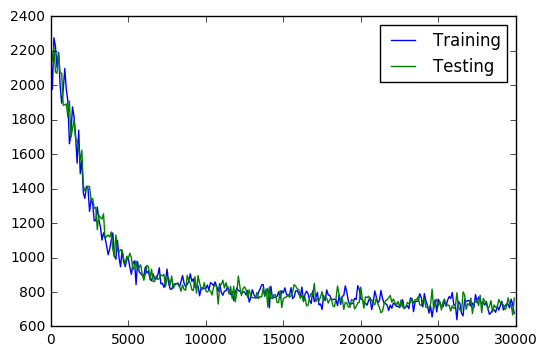

In [9]:
# We initialize the values
sess.run(tf.global_variables_initializer())

hist = numpy.ones([300,3])*numpy.nan
# Train
for i in range(30000):
    idx = numpy.random.permutation(training_data.shape[0])
    idx = idx[0:50]
    if i%100 == 0:
        train_loss = distance.eval(feed_dict={x:training_data[idx], y: training_data[idx]})
        idx = numpy.random.permutation(testing_data.shape[0])
        idx = idx[0:50]
        test_loss = distance.eval(feed_dict={x:testing_data[idx], y:testing_data[idx]})
        hist[i/100][0] = i
        hist[i/100][1] = train_loss
        hist[i/100][2] = test_loss
        clear_output()
        print("step %d, training loss %g, testing loss %g"%(i, train_loss, test_loss))
        plt.plot(hist[:,0],hist[:,1], label="Training")
        plt.plot(hist[:,0],hist[:,2], label="Testing")
        plt.legend()
        plt.savefig("autoencoder_loss_curve.pdf")
        plt.show()
    train_step.run(feed_dict={x: training_data[idx] , y: training_data[idx]})

We plot few samples from training data, and reconstructed images

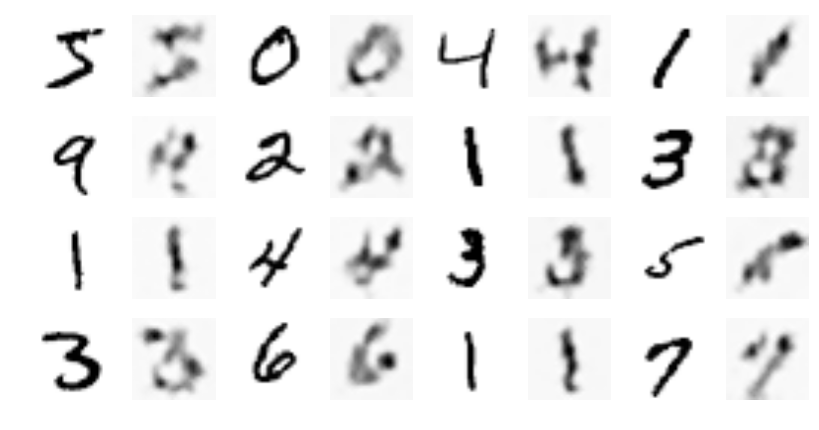

In [10]:
# Check if things are working expectedly
nb = 4
sample = training_data[0:nb*nb]
out= ygcnn.eval(feed_dict={x : sample})
fig = plt.figure(figsize=(10,5))

for i in range(sample.shape[0]):
    ax = fig.add_subplot(nb, 2*nb, 2*i+1)
    ax.axis('off')
    ax.imshow(numpy.reshape(sample[i], [28,28]), cmap="Greys")
    ax = fig.add_subplot(nb, 2*nb, 2*i+2)
    ax.axis('off')
    plt.imshow(numpy.reshape(out[i], [28,28]), cmap="Greys")
plt.savefig("reconstruction.pdf")
plt.show()

We plot the decodings of the indicators of the first variables of the code.

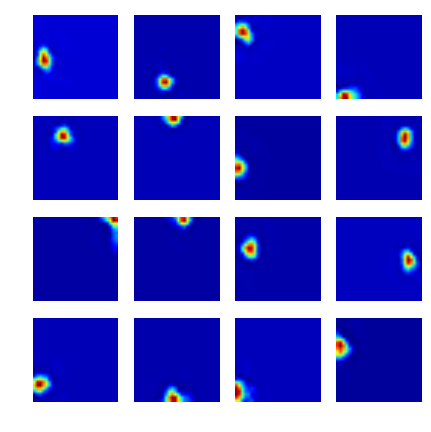

In [11]:
nb = 4
fig = plt.figure(figsize=(5,5))

for i in range(nb*nb):
    ax = fig.add_subplot(nb, nb, i+1)
    ax.axis('off')
    a = numpy.zeros([1,1,67])
    a[0,0,i] = 1
    b = y9.eval(feed_dict={y4p:a})
    plt.imshow(numpy.reshape(b,[28,28]))
plt.savefig('code.pdf')
plt.show()